In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
class CifarHelper():
    
    def __init__(self):
        
        self.i = 0
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = train_images / 255.0
        self.training_labels = self.one_hot_encode(train_labels) 
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = test_images / 255.0
        self.test_labels = self.one_hot_encode(test_labels)

    def one_hot_encode(self, vec):

        n = len(vec)
        out = np.zeros((n, 10))
        for i in range(n):
            out[i, vec[i]] = 1
        
        return out

        
    def next_batch(self, batch_size):
        
        x = self.training_images[self.i:self.i+batch_size]
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [ ]:
ch = CifarHelper()
ch.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [ ]:
# Convolutional layer
def conv_layer(input_x,w,b):

  y = tf.nn.conv2d(input=input_x,filters=w,strides=[1,1,1,1],padding='SAME') + b

  y = tf.nn.relu(y)

  return y

In [ ]:
# Pooling layer
def maxPool_layer(x,poolSize):

  return tf.nn.max_pool2d(input=x,ksize=[1,poolSize,poolSize,1],strides=[1,poolSize,poolSize,1],padding="SAME")

In [ ]:
# Fully connected layer
def fullyConnected_layer(input_layer,w,b):

  y = tf.matmul(input_layer,w) + b

  return y

In [ ]:
def get_tfVariable(shape, name):

  return tf.Variable(tf.random.truncated_normal(shape,stddev=0.1), name=name, trainable=True, dtype=tf.float32)

class my_model():

  def __init__(self):
    
    self.pool_size = 2
    self.dropout = 0.5
    self.nclasses = 10

    self.shapes = [
    [5, 5, 3, 32], 
    [5, 5, 32, 64],
    [8*8*64,512],
    [512, self.nclasses]
    ]

    self.weights = []
    for i in range(len(self.shapes)):
      self.weights.append( get_tfVariable(self.shapes[i] , 'weight{}'.format( i ) ) )

    self.bias = []
    for i in range(len(self.shapes)):
      self.bias.append( get_tfVariable([1,self.shapes[i][-1]] , 'bias{}'.format( i ) ) )



  def run(self, x_input):
    
    conv1 = conv_layer(x_input,self.weights[0],self.bias[0]) 
    pool1 = maxPool_layer(conv1,poolSize=self.pool_size)
    
    conv2 = conv_layer(pool1,self.weights[1],self.bias[1]) 
    pool2 = maxPool_layer(conv2,poolSize=self.pool_size)
    
    flat1 = tf.reshape(pool2,[-1,pool2.shape[1]*pool2.shape[2]*pool2.shape[3]])
    
    fully1 = tf.nn.relu(fullyConnected_layer(flat1,self.weights[2],self.bias[2]))
    
    fully1_dropout = tf.nn.dropout(fully1,rate=self.dropout)
    
    y_pred = fullyConnected_layer(fully1_dropout,self.weights[3],self.bias[3])

    return y_pred

  def trainable_variables(self):

    return self.weights + self.bias

In [ ]:
model = my_model()

In [ ]:
def loss_function(y_pred,y_true):
    
    return tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_true),logits=y_pred)

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=0.001)

In [ ]:
def train_step( model, x_input , y_true, epoch):

  epoch_accuracy = None
  epoch_loss_avg = None
    
  with tf.GradientTape() as tape:
        
    # Get the predictions
    preds = model.run(x_input)
        
    # Calc the loss
    current_loss = loss_function(preds,y_true)
    
    # Get the gradients
    grads = tape.gradient(current_loss, model.trainable_variables())
    
    # Update the weights
    optimizer.apply_gradients(zip(grads, model.trainable_variables()))
    
    if epoch%100 == 0:

      y_pred = model.run(ch.test_images)
      matches  = tf.equal(tf.math.argmax(y_pred,1), tf.math.argmax(ch.test_labels,1))

      epoch_accuracy = tf.reduce_mean(tf.cast(matches,tf.float32))
      epoch_loss_avg = tf.reduce_mean(current_loss)

      print("--- On epoch {} ---".format(epoch))
      tf.print("Accuracy: ", epoch_accuracy, "| Loss: ",epoch_loss_avg)
      print("\n")

    return epoch_accuracy,epoch_loss_avg

--- On epoch 0 ---
Accuracy:  0.1008 | Loss:  8.53578949


--- On epoch 100 ---
Accuracy:  0.3712 | Loss:  1.61025071


--- On epoch 200 ---
Accuracy:  0.4373 | Loss:  1.64894116


--- On epoch 300 ---
Accuracy:  0.4661 | Loss:  1.41963947


--- On epoch 400 ---
Accuracy:  0.4789 | Loss:  1.29361248


--- On epoch 500 ---
Accuracy:  0.5219 | Loss:  1.36562252


--- On epoch 600 ---
Accuracy:  0.5371 | Loss:  1.14305913


--- On epoch 700 ---
Accuracy:  0.556 | Loss:  1.31754744


--- On epoch 800 ---
Accuracy:  0.5453 | Loss:  1.2478354


--- On epoch 900 ---
Accuracy:  0.5631 | Loss:  0.937306046


--- On epoch 1000 ---
Accuracy:  0.5891 | Loss:  1.0882479


--- On epoch 1100 ---
Accuracy:  0.5851 | Loss:  0.882329166


--- On epoch 1200 ---
Accuracy:  0.6014 | Loss:  0.960128784


--- On epoch 1300 ---
Accuracy:  0.5904 | Loss:  1.14636016


--- On epoch 1400 ---
Accuracy:  0.5968 | Loss:  0.781337917


--- On epoch 1500 ---
Accuracy:  0.6095 | Loss:  0.991386712


--- On epoch 1600 

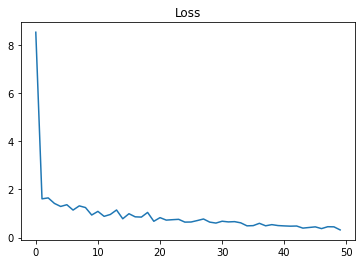

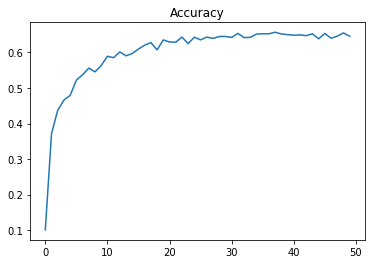

In [ ]:
num_epochs = 5000
batch_size = 100

train_loss_results = []
train_accuracy_results = []

for epoch in range(num_epochs):
    
  # Get next batch
  batch_x, batch_y = ch.next_batch(batch_size)
    
  # Train the model
  epoch_accuracy, epoch_loss_avg = train_step(model, batch_x, batch_y, epoch)

  if(epoch_loss_avg is not None):
    train_loss_results.append(epoch_loss_avg)
    train_accuracy_results.append(epoch_accuracy)

plt.plot(train_loss_results)
plt.title('Loss')
plt.show()
plt.title('Accuracy')
plt.plot(train_accuracy_results)
plt.show()

In [ ]:
n = 784
pred = model.run(ch.test_images[n:n+1])
tf.print(tf.math.argmax(pred,1))
tf.print(tf.math.argmax(ch.test_labels[n:n+1],1))

[7]
[7]
